In [7]:
# import dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df_path = '/content/drive/MyDrive/Colab Notebooks/datasets/CARES_data_predictionv1.csv'
data = pd.read_csv(df_path)

# data = data.drop('Mortality', axis=1)
data.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69667 entries, 0 to 69666
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   GENDER                             69667 non-null  object 
 1   Anemia category                    69667 non-null  object 
 2   Preoptransfusionwithin30days       69667 non-null  float64
 3   Intraop                            69667 non-null  float64
 4   Transfusionintraandpostop          69667 non-null  float64
 5   AnaestypeCategory                  69667 non-null  object 
 6   PriorityCategory                   69667 non-null  object 
 7   TransfusionIntraandpostopCategory  69667 non-null  object 
 8   AGEcategory                        69667 non-null  object 
 9   SurgRiskCategory                   69667 non-null  object 
 10  GradeofKidneyCategory              69667 non-null  object 
 11  RDW15.7                     

In [3]:
# create new variable ('ICUMortalityrisk_ind')
data['ICUMortalityrisk_ind'] = ((data['ICUAdmgt24h'] == 1) | (data['thirtydaymortality'] == True) | (data['Mortality'] == 'Yes')).astype(int)
data['ICUMortalityrisk_ind'].value_counts(normalize=True)

,proportion
ICUMortalityrisk_ind,
0,0.913101
1,0.086899


In [4]:
# Define categorical, numeric & target columns
# Define the target columns
# target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'ICUMortalityrisk_ind']
target_var = 'ICUAdmgt24h'
target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'Mortality', 'ICUMortalityrisk_ind']

# Select categorical columns and exclude target columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
cat_cols = [col for col in cat_cols if col not in target_cols]

# Select numerical columns and exclude target columns
num_cols = data.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col not in target_cols]

In [5]:
# If you are using Apple M1, M2, M3 on your local machine
if not torch.cuda.is_available() and torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        device = "mpu"
        print('mpu is here!')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Precision: 0.7614
Recall: 0.6968
F1-score: 0.7277
ROC AUC: 0.8870


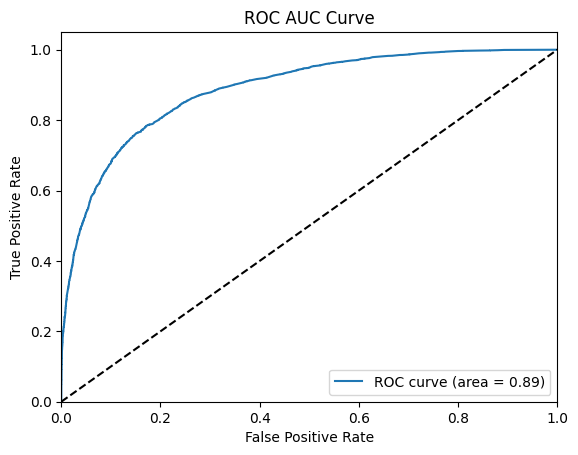

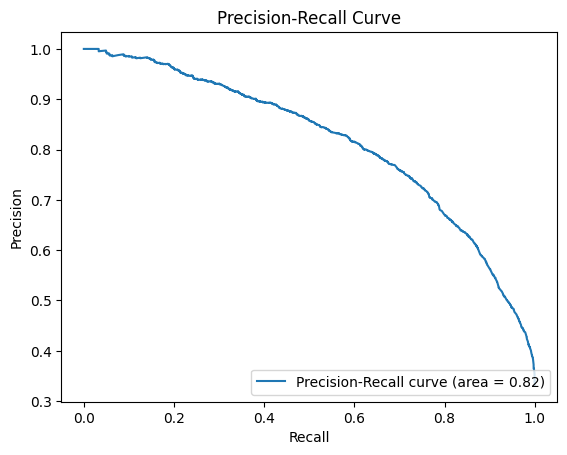

In [16]:
# 50:50 resampling!
# Preprocessing function
def preprocess_data(data, cat_cols, num_cols, target):
    # One-hot encode categorical variables
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_cat = encoder.fit_transform(data[cat_cols])
    encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(cat_cols))

    # Standardize numerical variables
    scaler = StandardScaler()
    scaled_num = scaler.fit_transform(data[num_cols])
    scaled_num_df = pd.DataFrame(scaled_num, columns=num_cols)

    # Combine encoded categorical and scaled numerical features
    X = pd.concat([encoded_cat_df, scaled_num_df], axis=1)
    y = data[target]

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42, sampling_strategy=0.5)
    X_res, y_res = smote.fit_resample(X, y)

    return X_res, y_res

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Function to train the model
def train_model(X_train, y_train, input_dim, epochs=20, batch_size=16, learning_rate=0.001):
    model = SimpleNN(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X_test.values, dtype=torch.float32)).squeeze()
        preds = (outputs >= 0.5).int()

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    roc_auc = roc_auc_score(y_test, outputs)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    # Plot ROC AUC curve
    fpr, tpr, _ = roc_curve(y_test, outputs)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot precision-recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, outputs)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure()
    plt.plot(recall_curve, precision_curve, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

# Load and preprocess the data
# Assuming 'data' is a pandas DataFrame
X_res, y_res = preprocess_data(data, cat_cols, num_cols, 'ICUMortalityrisk_ind')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train the model
input_dim = X_train.shape[1]
model = train_model(X_train, y_train, input_dim)

# Evaluate the model
evaluate_model(model, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Precision: 0.6766
Recall: 0.6077
F1-score: 0.6403
ROC AUC: 0.8798


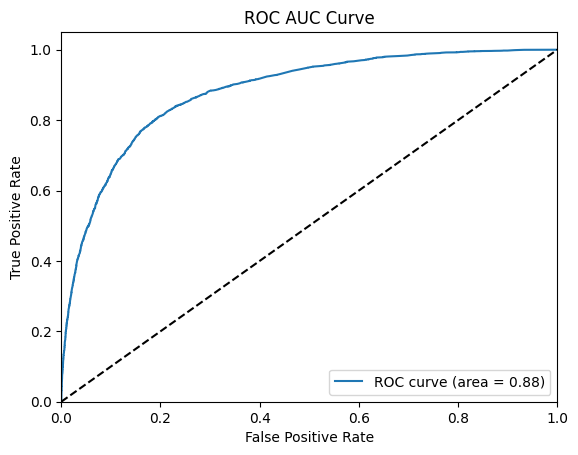

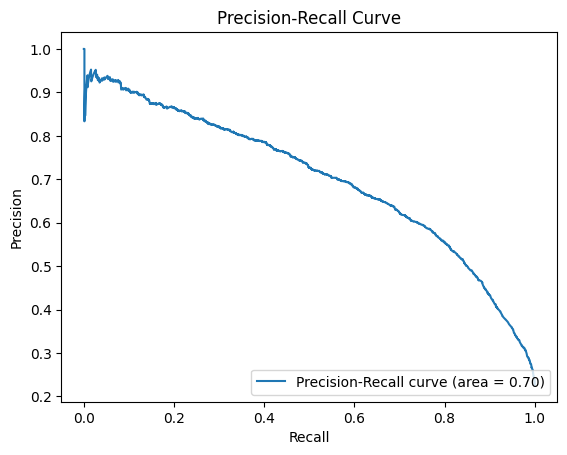

In [8]:
# 70:30 resampling!
# Preprocessing function
def preprocess_data(data, cat_cols, num_cols, target):
    # One-hot encode categorical variables
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_cat = encoder.fit_transform(data[cat_cols])
    encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(cat_cols))

    # Standardize numerical variables
    scaler = StandardScaler()
    scaled_num = scaler.fit_transform(data[num_cols])
    scaled_num_df = pd.DataFrame(scaled_num, columns=num_cols)

    # Combine encoded categorical and scaled numerical features
    X = pd.concat([encoded_cat_df, scaled_num_df], axis=1)
    y = data[target]

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42, sampling_strategy=0.3)
    X_res, y_res = smote.fit_resample(X, y)

    return X_res, y_res

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Function to train the model
def train_model(X_train, y_train, input_dim, epochs=20, batch_size=16, learning_rate=0.001):
    model = SimpleNN(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X_test.values, dtype=torch.float32)).squeeze()
        preds = (outputs >= 0.5).int()

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    roc_auc = roc_auc_score(y_test, outputs)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    # Plot ROC AUC curve
    fpr, tpr, _ = roc_curve(y_test, outputs)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot precision-recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, outputs)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure()
    plt.plot(recall_curve, precision_curve, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

# Load and preprocess the data
# Assuming 'data' is a pandas DataFrame
X_res, y_res = preprocess_data(data, cat_cols, num_cols, 'ICUMortalityrisk_ind')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train the model
input_dim = X_train.shape[1]
model = train_model(X_train, y_train, input_dim)

# Evaluate the model
evaluate_model(model, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-15-48dc06f91bc2>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(class_weights, dtype=torch.float32)


Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
ROC AUC: 0.5631


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


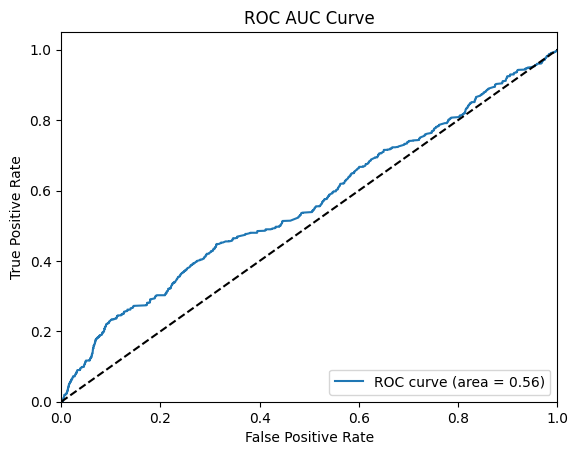

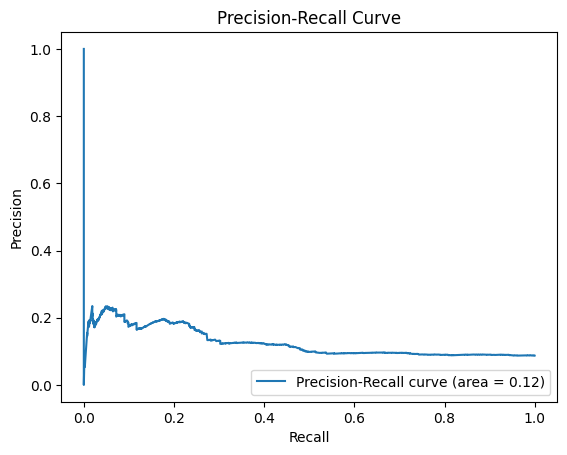

In [15]:
# without resampling!
# Preprocessing function
def preprocess_data(data, cat_cols, num_cols, target):
    # One-hot encode categorical variables
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_cat = encoder.fit_transform(data[cat_cols])
    encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(cat_cols))

    # Standardize numerical variables
    scaler = StandardScaler()
    scaled_num = scaler.fit_transform(data[num_cols])
    scaled_num_df = pd.DataFrame(scaled_num, columns=num_cols)

    # Combine encoded categorical and scaled numerical features
    X = pd.concat([encoded_cat_df, scaled_num_df], axis=1)
    y = data[target]

    # No resampling

    return X, y

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Function to train the model
def train_model(X_train, y_train, input_dim, class_weights=torch.tensor([0.7, 0.3]), epochs=20, batch_size=16, learning_rate=0.001):
    model = SimpleNN(input_dim)

    # Convert class weights to the appropriate type for PyTorch
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Use the default BCEWithLogitsLoss which is better for numerical stability
    criterion = nn.BCEWithLogitsLoss(reduction='none')  # 'none' to keep individual losses

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            outputs = model(X_batch).squeeze()

            # Compute the raw loss (without reduction)
            loss = criterion(outputs, y_batch)

            # Apply class weights to the loss
            weighted_loss = loss * (y_batch * class_weights[1] + (1 - y_batch) * class_weights[0])

            # Compute the mean loss
            loss = weighted_loss.mean()

            loss.backward()
            optimizer.step()

    return model



# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X_test.values, dtype=torch.float32)).squeeze()
        preds = (outputs >= 0.5).int()

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    roc_auc = roc_auc_score(y_test, outputs)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    # Plot ROC AUC curve
    fpr, tpr, _ = roc_curve(y_test, outputs)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot precision-recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, outputs)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure()
    plt.plot(recall_curve, precision_curve, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

# Load and preprocess the data
# Assuming 'data' is a pandas DataFrame
X_res, y_res = preprocess_data(data, cat_cols, num_cols, 'ICUMortalityrisk_ind')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train the model
input_dim = X_train.shape[1]
model = train_model(X_train, y_train, input_dim)

# Evaluate the model
evaluate_model(model, X_test, y_test)